#  RAG with Reranker for 10-K filings

## What is this Notebook About?

This notebook demonstrates a **Retrieval-Augmented Generation (RAG)** system enhanced with a **Reranking** mechanism. Let's break down these concepts:

### **What is RAG (Retrieval-Augmented Generation)?**
RAG is a technique that combines two powerful AI approaches:
1. **Retrieval**: Finding relevant documents/information from a knowledge base (like a database or document collection)
2. **Generation**: Using an AI language model to generate answers based on the retrieved information

Instead of relying solely on an LLM's training data, RAG retrieves specific, relevant documents first, then feeds them as context to the LLM to generate accurate, up-to-date answers. This approach is particularly useful for answering questions about specific documents like 10-K filings.

### **What is Reranking?**
In a basic RAG system, initial document retrieval uses embedding-based similarity search (fast but sometimes inaccurate). **Reranking** is a refinement step that uses a more sophisticated AI model (cross-encoder) to re-examine the retrieved documents and reorder them by true relevance to the query. This ensures the most relevant documents are prioritized for the LLM.

### **What are 10-K Filings?**
A 10-K is an annual report that public companies are required to file with the U.S. Securities and Exchange Commission (SEC). It contains comprehensive financial and operational information about the company.

## Objective of This Exercise

The objective of this notebook is to develop a prototype of a RAG system capable of answering questions based on Tesla's 10-K filings. Specifically, we will:
1. Compare RAG responses **without** reranking vs **with** reranking
2. Demonstrate how reranking improves answer quality
3. Answer the following question: **"List the major changes that occurred in the company in 2023?"**

**Note**: The spelling mistakes in the query ("majour" instead of "major", "occoured" instead of "occurred") are intentional. This tests the system's robustness to user input variations.

**Data Source**: Tesla's 10-K filing from the SEC website (fiscal year 2023)


# How to Run this Notebook?

This notebook builds upon the notebook for Exercise 1: RAG with noReranker. The explanations that repeat from the previous notebook are greyed out in this notebook.

1. Generate API key for OpenAI (ChatGPT): https://platform.openai.com/settings/organization/api-keys
Make sure to save the API key. You'll get to see the key only once at the time of generation. If you miss copying the key, you may need to generate a new key.
2. Click on 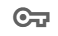 icon in the left menu bar of this Notebook

3. Click `+ Add new secret `
- <font color="#d3d3d3">Add OpenAI key, if not added already:
  * <font color="#d3d3d3">Under Name copy paste: `OPENAI_KEY`
  * Under Value copy paste: OpenAI key you saved earlier

4. Enable access to the keys for this notebook by toggling the radio buttons in the `Secrets` section.
5. Close the `Secrets` section once done.
6. Click `Run all` under the `Runtime` in top menu to execute this notebook`

#Basic Setup


## Install Frameworks

### **What are we installing?**

Below is a brief explanation of each framework and library:

**LangChain Ecosystem:**
- `langchain`: A framework that simplifies building applications with Large Language Models (LLMs)
- `langchain_core`: Core abstractions and interfaces for LangChain
- `langchain_community`: Community integrations with external services and databases
- `langchain_huggingface`: Integration with HuggingFace models for embeddings
- `langchain_openai`: Integration with OpenAI's API for using GPT models

**Vector Search & Embeddings:**
- `faiss-cpu`: Facebook's open-source library for fast similarity search and clustering of vectors. It's optimized for CPU performance and is essential for storing and retrieving document embeddings efficiently
- `openai==1.56.2`: OpenAI's official Python client library for accessing their APIs
- `langchain_openai`: LangChain's wrapper around OpenAI's APIs

**Reranking:**
- `flashrank`: A fast, efficient reranking library that uses lightweight models to reorder retrieved documents by relevance
- `langchain_cohere`: LangChain's integration with Cohere's API (an alternative reranking option)

**Why these tools matter in our RAG pipeline:**
- **LangChain**: Orchestrates the entire RAG workflow (retrieval → reranking → generation)
- **FAISS**: Stores embeddings and performs fast semantic search
- **HuggingFace Embeddings**: Converts text into numerical representations (embeddings) for similarity search
- **OpenAI/GPT**: Generates the final answer based on context
- **Flashrank**: Reranks retrieved documents to ensure the most relevant ones are used


In [ ]:
%%capture
!pip install langchain langchain_core langchain_community faiss-cpu openai langchain_openai langchain_huggingface -U

In [ ]:
# New installs
%%capture
!pip install -q U flashrank  # for Flashrank monkeypatch


In [ ]:
import importlib.metadata
print(importlib.metadata.version("flashrank"))


0.2.10


In [ ]:
import langchain
print(f"langchain version: {langchain.__version__}")

langchain version: 1.0.5


## API Keys Setup

### **Why do we need API keys?**
An API key is a unique credential that authenticates your requests to external services. In this notebook, we need:

- **OpenAI API Key**: Required to use GPT models for generating answers. You'll need to create an account at OpenAI and generate a key from their dashboard.
- **HuggingFace API Key** (optional): Some embedding models may require authentication
- **Cohere API Key** (optional): Alternative reranking service

### **How to set up in Google Colab:**

<font color="#d3d3d3">
**Important**: You need to setup your API keys in Google Colab's Secrets manager (a secure way to store credentials without exposing them in code). Click on the key icon in the left sidebar, then add your keys as:

- `OPEN_AI_KEY` for OpenAI API Key

**Security Note**: Never share your API keys! They grant access to your account and can incur costs. Always keep them confidential.
</font>


In [ ]:
import os

if 'google.colab' in str(get_ipython):
    from google.colab import userdata
    # Set environment variables
    os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_AI_KEY')


## Google Drive and Local Path Setup

### **What are we doing here?**

When running in Google Colab, we need to:
1. **Mount Google Drive**: Connect your Google Drive to the Colab environment so we can read/write files
2. **Create a FAISS Index Directory**: FAISS (Facebook AI Similarity Search) creates large vector store files that need to be stored. We create a directory to save the vector store locally.

### **Why is this important?**
- FAISS vector stores can be large (depending on the number of documents)
- By saving to Google Drive, we can reuse the same vector store across multiple notebook runs
- This avoids recreating embeddings every time, which is computationally expensive


In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up paths
gdrive_root = Path('/content/drive/My Drive')
faiss_dir = gdrive_root/"LLM_Fall/RAG/faiss_index"
faiss_dir.mkdir(parents=True, exist_ok=True)

## Import Libraries

### **What are we importing?**

Here we import all the necessary components for building our RAG pipeline. Let's understand each category:

**Document Processing:**
- `WebBaseLoader`: Loads and parses documents from web URLs
- `RecursiveCharacterTextSplitter`: Breaks large documents into smaller, manageable chunks (essential for RAG, as embedding models have input length limits)

**Embeddings & Vector Search:**
- `HuggingFaceEmbeddings`: Converts text into numerical embeddings (vector representations) for semantic search
- `FAISS`: Facebook's vector database that stores and retrieves embeddings efficiently

**LLM & Prompt Management:**
- `ChatOpenAI`: Interface to OpenAI's GPT models
- `PromptTemplate`: Structures how we format input for the LLM
- `StrOutputParser`: Parses and returns LLM output as text

**RAG Pipeline Components:**
- `RunnablePassthrough`: Passes data through unchanged (useful in LCEL chains)
- `ContextualCompressionRetriever`: Orchestrates retrieval + reranking in a single retriever
- `Document`: Represents a text document with metadata (e.g., source URL, page number)

**Reranking:**
- `FlashrankRerank`: Reranks retrieved documents using lightweight cross-encoder models
- `Ranker`: The underlying reranking engine

These components work together to create an efficient RAG pipeline.


In [ ]:
# LangChain imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from pprint import pprint

from typing import List
from langchain_classic.retrievers import ContextualCompressionRetriever


In [ ]:
# New imports
from flashrank import Ranker, RerankRequest
import langchain_community.document_compressors.flashrank_rerank as fr_mod
fr_mod.RerankRequest = RerankRequest

from langchain_community.document_compressors import FlashrankRerank

# Configuration Dictionary

### **What is a Configuration Dictionary?**
A configuration dictionary is a centralized place where we store all the settings and parameters for our RAG system. Instead of hardcoding values throughout the notebook, we define them once and reuse them. This makes the code more maintainable and allows us to easily experiment with different settings.

### **What does each configuration parameter do?**

**Document Processing Settings:**
- `chunkSize`: Size of text chunks (in characters) when splitting documents. Smaller chunks = more specific, larger chunks = more context
- `chunkOverlap`: Overlap between consecutive chunks (in characters). Overlap ensures context isn't lost at chunk boundaries
- `userAgentHeader`: Identifies your application when fetching documents from the web (polite practice)

**Embedding Model Settings:**
- `embeddingModel`: The model used to convert text into numerical embeddings. "BAAI/bge-base-en-v1.5" is a HuggingFace model optimized for semantic search
- Note: Embeddings are numerical representations that capture the semantic meaning of text, enabling similarity search

**Vector Store & Retrieval Settings:**
- `numRetrievedDocuments`: Number of documents initially retrieved by semantic search (12 documents). More documents = broader search, but slower
- `numSelectedDocuments`: Number of documents passed to the LLM for answer generation (5 documents). Balances context quality with token costs

**Reranking Settings:**
- `rerankerType`: Type of reranker to use ("flashrank" = lightweight, fast cross-encoder)
- `rerankerModel`: Specific reranking model ("ms-marco-TinyBERT-L-2-v2" is small but effective)
- `numRerankedDocuments`: Number of documents returned after reranking (5 documents). These are the most relevant documents

**LLM Settings:**
- `ragAnswerModel`: The language model for generating answers ("gpt-4o" = OpenAI's GPT-4 Omni model)
- `ragAnswerModelTemperature`: Controls randomness in responses (0.7 = balanced, 0.0 = deterministic, 1.0 = very random)

**Data Source:**
- `companyFilingUrls`: URL(s) to the 10-K filings we'll process

**Prompt Template:**
- `ragPromptTemplate`: The instruction template that tells the LLM how to format its response using the provided context


In [ ]:
defaultConfig = {
    # Document processing settings
    "chunkSize": 500,
    "chunkOverlap": 50,
    "userAgentHeader": "YourCompany-ResearchBot/1.0 (your@email.com)",

    # embedding model
    "embeddingModel": "BAAI/bge-base-en-v1.5",

    # Vector store settings
    "numRetrievedDocuments": 12,

    # Document formater settings
    "numSelectedDocuments": 5,

    # Reranker setting
    "rerankerType": "flashrank",
    "rerankerModel": "ms-marco-TinyBERT-L-2-v2",
    "numRerankedDocuments": 5,

    # Model settings
    "ragAnswerModel": "gpt-4o",
    "ragAnswerModelTemeprature": 0.7,

    # URLs to process
    "companyFilingUrls": [
        ("Tesla", "https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm")
    ],

    # RAG prompt template
    "ragPromptTemplate": """
    Give an answer for the `Question` using only the given `Context`. Use information relevant to the query from the entire context.
    Provide a detailed answer with thorough explanations, avoiding summaries.

    Question: {question}

    Context: {context}

    Answer:
    """
}

In [ ]:
config = defaultConfig.copy() # Creates a separate copy of the default configuration dictionary (defaultConfig) so that any subsequent changes won't alter the original default settings.

# Load Vector Store

### **What is a Vector Store?**

A vector store is a database optimized for storing and searching numerical embeddings (vectors). Here's the concept:

1. **Embeddings**: When documents are processed, each chunk is converted into a numerical vector (embedding) using an embedding model. These vectors capture semantic meaning—similar documents have similar vectors.

2. **Vector Store**: A specialized database that stores these vectors and can quickly find the most similar vectors to a query using distance metrics (like cosine similarity).

3. **FAISS Index**: FAISS (Facebook AI Similarity Search) creates highly optimized indexes for fast similarity search. It's one of the most efficient vector store implementations.

### **Why are we loading a pre-existing vector store?**

Creating embeddings is computationally expensive (requires processing and embedding all documents). By saving the vector store from our previous notebook, we can reuse it without regenerating embeddings. This is a common practice in production RAG systems.

### **What happens in this section?**

We will:
1. Initialize an embedding function (the same model used to create the original embeddings)
2. Load the FAISS index from disk
3. This vector store is now ready for retrieval operations in our RAG pipeline


In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model_name = config.get('embeddingModelName', 'text-embedding-3-small')

if embedding_model_name.startswith("text-embedding"):
    # Use OpenAIEmbeddings for OpenAI models
    embeddingFunction = OpenAIEmbeddings(model=embedding_model_name)
else:
    # Use HuggingFaceEmbeddings for other models (assuming they are from HuggingFace)
    embeddingFunction = HuggingFaceEmbeddings(model_name=embedding_model_name)

loaded_vectorstore = FAISS.load_local(str(faiss_dir), embeddingFunction, allow_dangerous_deserialization=True)

# Retriever

### **What is a Retriever?**

A retriever is a component that fetches relevant documents from a knowledge base based on a query. In our case:

1. **Input**: A user question (e.g., "What technological advancements were made in Tesla's batteries?")
2. **Process**: The question is converted to an embedding, then compared against all document embeddings in the vector store using similarity search
3. **Output**: The top-K most similar documents (in our config: 12 documents)

### **How does semantic similarity work?**

- Documents and queries are both converted to vectors using an embedding model
- Similarity is calculated using cosine similarity: vectors pointing in similar directions = similar content
- This is **fast** (milliseconds for large databases) but may not capture subtle nuances

### **Why 12 documents?**

- Retrieving more documents casts a wider net, increasing the chance of finding relevant information
- But more documents means more noise and higher costs (more tokens for the LLM)
- The trade-off: 12 is a good balance for most use cases
- Later, reranking will filter these down to the 5 most relevant ones


In [ ]:
retriever = loaded_vectorstore.as_retriever(search_kwargs={"k": config["numRetrievedDocuments"]})

In [ ]:
retrieved_documents = retriever.invoke("What technological advancements were made in the batteries used in Tesla's Electric Vehicles?")

In [ ]:
retrieved_documents

[Document(id='6479de32-a721-41b5-9ac8-5434aab44823', metadata={'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'company': 'Tesla'}, page_content='technology featuring three electric motors for further increased performance in certain versions of Model S and Model X, Cybertruck and the Tesla Semi.We maintain extensive testing and R&D capabilities for battery cells, packs and systems, and have built an expansive body of knowledge on lithium-ion cell chemistry types and performance characteristics. In order to enable a greater supply of cells for our products with higher energy density at lower costs, we have developed a new proprietary'),
 Document(id='a9da26b9-1493-4255-91f4-2e38055e6acf', metadata={'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'company': 'Tesla'}, pag

#  Reranker: Improving Retrieval Quality

## Why Reranking in RAG?

### **The Problem with Initial Retrieval**

Standard RAG systems use **bi-encoder embedding models** for initial retrieval:
- **How they work**: The query and each document are encoded separately into vectors, then compared using cosine similarity
- **Advantage**: Very fast, can handle millions of documents
- **Disadvantage**: Limited - they miss nuanced relevance, context-dependent relationships, and subtle semantic connections

### **The Reranking Solution**

Rerankers use **cross-encoder models** that solve this problem:
- **How they work**: The query and document are processed together as a pair, allowing the model to directly analyze their interaction and relationship
- **What they capture**: Complex semantic relationships, contextual relevance, and precise relevance judgments that bi-encoders miss
- **Trade-off**: Slower than bi-encoders, so we only use them on the top-K retrieved results (not all documents)

### **Two-Stage Retrieval Architecture**

Our RAG system uses a smart two-stage approach:

```
Stage 1: Fast Retrieval (Bi-encoder)
├─ Query encoded separately → Search vector store
└─ Return top 12 most similar documents

Stage 2: Precise Reranking (Cross-encoder)
├─ Take those 12 documents
├─ Evaluate query-document pairs together
└─ Return top 5 most relevant documents

Final Stage: Generation
├─ Pass top 5 documents as context to LLM
└─ LLM generates answer
```

### **Real-World Impact**

In large document collections (thousands to millions of chunks), retrieval errors are common. A document might rank high based on keyword similarity but actually be irrelevant to the semantic query. Reranking corrects these errors, ensuring high-quality context for the LLM.

**Flashrank** is a lightweight, efficient reranking library that uses TinyBERT models—small but powerful cross-encoders optimized for speed.


In [ ]:
# Config (adjust as needed)
model_name = config.get("rerankerModel", "ms-marco-TinyBERT-L-2-v2")
top_n = int(config.get("numRerankedDocuments", 5))

# Create client + LC wrapper
ranker_client = Ranker(model_name=model_name)
reranker = FlashrankRerank(client=ranker_client, model=model_name, top_n=top_n)


ms-marco-TinyBERT-L-2-v2.zip: 100%|██████████| 3.26M/3.26M [00:00<00:00, 138MiB/s]


In [ ]:
query = "List the majour changes that occoured in the company in 2023"
reranked_docs = reranker.compress_documents(retrieved_documents, query)  # Returns 5 docs


In [ ]:
reranked_docs

[Document(metadata={'id': 7, 'relevance_score': np.float32(0.06566119), 'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'company': 'Tesla'}, page_content='as of December 31, 2023. The Company provides a manufacturer’s warranty on all new and used Tesla vehicles. A warranty reserve is accrued for these products sold, which includes management’s best estimate of the projected costs to repair or replace items under warranty and recalls if identified. These estimates are based on actual claims incurred to date and an estimate of the nature, frequency and costs of future claims.The principal considerations for our determination that performing'),
 Document(metadata={'id': 4, 'relevance_score': np.float32(7.1485716e-05), 'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'compan

## ContextualCompressionRetriever

### **What is ContextualCompressionRetriever?**

ContextualCompressionRetriever is a LangChain component that combines two operations into a single, unified retriever:

1. **Base Retrieval**: Fetches initial documents from the vector store (bi-encoder based, fast)
2. **Compression/Reranking**: Reranks those documents using a cross-encoder (more accurate but slower)

Think of it as a pipeline: retrieve many → filter to best → return.

### **Architecture**

```
ContextualCompressionRetriever
├─ base_retriever: FAISS vector store retriever
│   └─ Returns top 12 documents based on embedding similarity
└─ base_compressor: Flashrank reranker
    └─ Reranks those 12 documents and returns top 5
```

### **Why Use ContextualCompressionRetriever?**

**Without ContextualCompressionRetriever**, you'd need to:
```python
docs = retriever.invoke(query)           # Get 12 docs
reranked = reranker.compress_documents(docs, query)  # Rerank manually
```

**With ContextualCompressionRetriever**, you can:
```python
docs = retriever.invoke(query)  # Done! Automatically handles both steps
```

### **Key Advantages**

1. **Single Interface**: Acts like a regular retriever, but with reranking built-in
2. **Cleaner Code**: Abstracts away the complexity of manually orchestrating retrieval + reranking
3. **Production-Ready**: 
   - Proper error handling (e.g., if reranker fails, falls back to base retrieval)
   - Callback support for monitoring and debugging
   - Handles edge cases (empty results, malformed documents, etc.)
4. **Scalability**: Can be easily swapped in/out in any RAG pipeline
5. **Async Support**: Built-in support for asynchronous operations for high-throughput scenarios

### **How it improves RAG**

By ensuring only the most relevant documents are passed to the LLM, ContextualCompressionRetriever:
- Reduces token usage (smaller context = lower costs)
- Improves answer quality (less noise and irrelevant information)
- Speeds up generation (LLM has less to process)


In [ ]:
from langchain_classic.retrievers import ContextualCompressionRetriever

retriever = ContextualCompressionRetriever(
        base_compressor = reranker, base_retriever = retriever
    )

In [ ]:
retriever.invoke(query)

[Document(metadata={'id': 2, 'relevance_score': np.float32(0.63399494), 'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'company': 'Tesla'}, page_content='of its operations and its cash flows for each of the three years in the period ended December 31, 2023 in conformity with accounting principles generally accepted in the United States of America. Also in our opinion, the Company maintained, in all material respects, effective internal control over financial reporting as of December 31, 2023, based on criteria established in Internal Control - Integrated Framework (2013) issued by the COSO.Changes in Accounting PrinciplesAs discussed in Note 2'),
 Document(metadata={'id': 10, 'relevance_score': np.float32(0.5138425), 'source': 'https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm', 'title': 'tsla-20231231', 'language': 'No language found.', 'com

In [ ]:
def create_retriever_with_reranking(vectorstore, config, use_reranking = True ):
    """
    Creates a retriever with optional reranking capability.

    Args:
        vectorstore: The vector store to retrieve from
        config: Configuration dictionary
        use_reranking: Whether to use reranking (default: True)

    Returns:
        A retriever (either basic or with reranking)
    """
    # Create base retriever
    base_retriever = vectorstore.as_retriever(
        search_kwargs={"k": config.get("numRetrievedDocuments", 12)}
    )

    # If reranking is disabled, return the base retriever
    if not use_reranking:
        return base_retriever

    try:
        # Initialize the reranker
        model_name = config.get("rerankerModel", "ms-marco-TinyBERT-L-2-v2")
        top_n = int(config.get("numRerankedDocuments", 5))
        ranker_client = Ranker(model_name=model_name)
        reranker = FlashrankRerank(client=ranker_client, model=model_name, top_n=top_n)


        # Create and return the enhanced retrieval system
        return ContextualCompressionRetriever(base_retriever=base_retriever, base_compressor=reranker)
    except Exception as e:
        print(f" Error setting up reranker: {e}")
        print("Falling back to base retriever.")
        return base_retriever

# RAG Chain: Putting It All Together

## What is a RAG Chain?

A RAG chain is a pipeline that connects all components of a Retrieval-Augmented Generation system into a cohesive workflow. Each component processes the input and passes its output to the next component.

### **RAG Chain Components & Flow**

```
User Query
    ↓
[RETRIEVER] - Fetch relevant documents from vector store
    ├─ Semantic similarity search (bi-encoder)
    └─ Rerank results (cross-encoder) 
    ↓
[DOCUMENT FORMATTER] - Convert documents into readable context
    ├─ Select top-5 documents
    └─ Format as: "Company Name\nDocument Content"
    ↓
[PROMPT TEMPLATE] - Structure the input for the LLM
    ├─ Question: {user query}
    └─ Context: {formatted documents}
    ↓
[LLM] - Generate answer based on context
    ├─ Model: GPT-4o
    └─ Temperature: 0.7 (balanced creativity)
    ↓
[OUTPUT PARSER] - Extract and format the response
    ↓
Final Answer
```

### **Component Descriptions**

1. **Retriever**: Searches the vector store and optionally reranks documents
   - Without reranking: Fast but potentially less accurate
   - With reranking: Slower but ensures relevant documents are selected

2. **Document Formatter**: Transforms raw documents into readable text
   - Extracts document content and metadata (company name)
   - Limits to top-5 documents to control context size
   - Joins documents with clear separators for the LLM

3. **LLM (Large Language Model)**: The "brain" that generates answers
   - Takes the formatted context and question
   - Uses its training to synthesize an answer based only on provided context
   - GPT-4o is chosen for its reasoning capabilities and cost-effectiveness

4. **Prompt Template**: Instructions that guide the LLM
   - Tells the LLM to only use provided context (not general knowledge)
   - Requests detailed answers with thorough explanations
   - Structures the input in a clear format

5. **Output Parser**: Extracts the text response from the LLM
   - The LLM returns structured objects; the parser extracts just the text

### **LCEL (LangChain Expression Language)**

The code uses LCEL, LangChain's composable syntax:
```python
retriever | format_docs  # Pass retriever output to formatter
| prompt               # Pass to prompt template
| llm                 # Pass to LLM
| parser              # Parse the output
```

This pipe syntax (`|`) chains components together, making the pipeline easy to read and modify.

### **Why Separate Retrieval from Formatting?**

The LCEL chain separates concerns:
- Retriever handles document search
- Formatter handles document presentation
- Prompt handles instruction
- LLM handles generation

This modular design makes it easy to swap components (e.g., use a different reranker or LLM) without changing the entire pipeline.


In [ ]:
def create_rag_chain(vectorstore, config, use_reranking=True):
    """
    Creates a RAG chain with optional reranking.

    Args:
        vectorstore: The vector store
        config: Configuration dictionary
        use_reranking: Whether to use reranking

    Returns:
        A runnable RAG chain
    """
    # Create retriever with optional reranking
    retriever = create_retriever_with_reranking(
        vectorstore=vectorstore,
        config=config,
        use_reranking=use_reranking
    )

    # Define formatting function
    def format_docs(docs):
        return "\n\n".join([
            f"{doc.metadata.get('company', '')}\n{doc.page_content}"
            for doc in docs[:config.get("numSelectedDocuments", 5)]
        ])

    # Create LLM
    llm = ChatOpenAI(
        model=config["ragAnswerModel"],
        temperature=config.get("ragAnswerModelTemperature", 0.7)
    )

    # Create prompt
    prompt = PromptTemplate.from_template(config["ragPromptTemplate"])

    # Build and return RAG chain
    return (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

In [ ]:
rag_chain_with_reranking = create_rag_chain(loaded_vectorstore, config, use_reranking=True)
rag_chain_without_reranking = create_rag_chain(loaded_vectorstore, config, use_reranking=False)

# Question

Note: The spelling mistakes in the query are intentional. We use only one 10-K document to ensure that the code runs within a reasonable time in the free Colab version, thereby reducing preprocessing time. The retrieval performs well even without the Reranker for many queries due to the smaller number of chunks. Therefore, to demonstrate the value of the Reranker, we identified a query that consistently underperforms without reranker.

In real-world scenarios, datasets are much larger and cosine based similarity often make mistakes in ranking chunks. Hence, a base retriever alone is typically insufficient without a Reranker.

In [ ]:
question = "List the majour changes that occoured in the company in 2023"

# Answer without ReRanking

In [ ]:
answer_without_reranking = rag_chain_without_reranking.invoke(question)
pprint(answer_without_reranking)

('In 2023, Tesla underwent several major changes, particularly in its '
 'financial structure and operational strategies. Here are the detailed '
 'changes:\n'
 '\n'
 '1. **Restructuring and Other Financial Adjustments**: In the context '
 'provided for the year 2023, there is a noted absence of restructuring costs, '
 'contrasting with the significant restructuring costs of $176 million '
 'recorded in 2022. This indicates a potential stabilization or completion of '
 'major restructuring efforts that were previously necessary.\n'
 '\n'
 '2. **Selling, General, and Administrative (SG&A) Expenses**: Tesla '
 'experienced a notable increase in its SG&A expenses in 2023, with these '
 'costs rising to $4,800 million from $3,946 million in 2022, reflecting a '
 '$854 million increase, which constitutes a 22% rise. This increase could be '
 'attributed to expanded operations, increased personnel costs, or investment '
 'in marketing and sales efforts. As a percentage of revenue, SG&A expen

# Answer with ReRanking



In [ ]:
answer_with_reranking = rag_chain_with_reranking.invoke(question)
pprint(answer_with_reranking)

('In 2023, Tesla experienced several notable changes and developments:\n'
 '\n'
 '1. **Financial Reporting and Internal Controls:**\n'
 '   - Tesla continued to maintain effective internal control over financial '
 'reporting as of December 31, 2023, in accordance with the criteria '
 'established in the Internal Control - Integrated Framework (2013) issued by '
 'COSO. Despite concerns that the degree of compliance with policies or '
 'procedures may deteriorate, no material changes in internal control over '
 'financial reporting were noted during the last quarter of 2023.\n'
 '\n'
 '2. **Changes in Accounting Principles:**\n'
 "   - The company's financial statements for the period ending December 31, "
 '2023, were prepared in conformity with generally accepted accounting '
 'principles in the United States. Specific changes in accounting principles '
 'were discussed in Note 2, though the exact nature of these changes is not '
 'detailed in the provided context.\n'
 '\n'
 '3. **Fi